In [1]:
"""Topic: Use different regression models such as linear, polynomial, lasso, and ridge to predict amount of fantasy points an NFL Running Back will have in the following game based off of previous game stats.

Independent Variable (Features): Rushing Yards, Rushing Touchdowns, Carries, Receptions, Yards/Target,Receptions/Yard, Receiving Touchdowns, Receiving Yards, Fumbles

Dependent Variable (Target): Fantasy Football Points for next game 

Source: Data scraped from Pro-Football-Reference

Methodology: Apply all regression models as aforementioned and compare Train, Validation, and Test R^2 values to determine best for model. Utilize other regression models such as LASSO and Ridge to Feature Engineer. Create running average of statistics for entire 2019 season (ie.: If Game 3 and predicting Fantasy Points for Game 4, then Game 3 statistics will be an average of games 1, 2, and 3.)

Deliverable: Present model with the best RSME score to determine how many points model comes within actual score. Reduce RSME as much as possible to create most accurate model. 

Future Iterations: Aggregate Features on 4-week running averages (ie.: Game 5 features predicting Fantasy Points for Game 6, average statistics from Games 2,3,4, and 5)
"""

# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../helper_functions')

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np

from stat_functions import all_position_stats, all_rb_defense_headers
from get_df import fantasy_points, get_running_back_df, all_individual_stats

import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import patsy
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

from yellowbrick.features import Rank2D
from yellowbrick.regressor import ResidualsPlot, PredictionError

import statsmodels.formula.api as smf
import statsmodels.api as sm


# Section 1

## Section 1.1
Web scrape data from Pro-Football-Reference for Running Backs with around 500 rushing yards or above. Pull individual statistics for each running back, for each game for the 2019 season. 

In [2]:
df_all_running_backs_2019 = all_position_stats('2019','rushing', 37)
df_all_running_backs_2019.columns = all_rb_defense_headers('2019','rushing')

df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']] = df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']].apply(pd.to_numeric)
df_all_running_backs_2019 = df_all_running_backs_2019[(df_all_running_backs_2019.Pos != 'QB')]
df_all_running_backs_2019.to_pickle("../pickled/df_all_running_backs_2019.pkl")
df_all_running_backs_2019 = pd.read_pickle("../pickled/df_all_running_backs_2019.pkl")
df_all_running_backs_2019


,Link,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb
Derrick Henry,/players/H/HenrDe00.htm,Derrick Henry *,TEN,25,RB,15,15,303,1540,16,73,74,5.1,102.7,5
Ezekiel Elliott,/players/E/ElliEz00.htm,Ezekiel Elliott*,DAL,24,RB,16,16,301,1357,12,78,33,4.5,84.8,3
Nick Chubb,/players/C/ChubNi00.htm,Nick Chubb*,CLE,24,RB,16,16,298,1494,8,62,88,5.0,93.4,3
Christian McCaffrey,/players/M/McCaCh01.htm,Christian McCaffrey *+,CAR,23,RB,16,16,287,1387,15,57,84,4.8,86.7,1
Chris Carson,/players/C/CarsCh00.htm,Chris Carson,SEA,25,RB,15,15,278,1230,7,75,59,4.4,82.0,7
Joe Mixon,/players/M/MixoJo00.htm,Joe Mixon,CIN,23,RB,16,15,278,1137,5,56,41,4.1,71.1,0
Leonard Fournette,/players/F/FourLe00.htm,Leonard Fournette,JAX,24,RB,15,15,265,1152,3,55,81,4.3,76.8,1
Dalvin Cook,/players/C/CookDa01.htm,Dalvin Cook*,MIN,24,RB,14,14,250,1135,13,60,75,4.5,81.1,4
Marlon Mack,/players/M/MackMa00.htm,Marlon Mack,IND,23,RB,14,12,247,1091,8,67,63,4.4,77.9,0
Sony Michel,/players/M/MichSo00.htm,Sony Michel,NWE,24,RB,16,14,247,912,7,55,26,3.7,57.0,2


In [3]:
all_running_backs_2019 = all_individual_stats(get_running_back_df, df_all_running_backs_2019, '2019')
all_running_backs_2019.to_pickle("../pickled/all_running_backs_2019.pkl")

all_running_backs_2019 = pd.read_pickle("../pickled/all_running_backs_2019.pkl")
all_running_backs_2019

,index,Name,Carries,Rush_Yards,Yards_per_Carry,Rush_TD,Targets,Receptions,Receiving_Yards,Y/R,Receiving_TD,Y/Tgt,Total_TDs,Pts,Fumbles
0,0,Derrick Henry,19.0,84.0,4.42,1.0,2.0,1.0,75.0,75.0,1.0,37.5,2.0,12,0.0
1,1,Derrick Henry,15.0,82.0,5.47,1.0,3.0,2.0,12.0,6.0,0.0,4.0,1.0,6,1.0
2,2,Derrick Henry,17.0,44.0,2.59,1.0,2.0,1.0,2.0,2.0,0.0,1.0,1.0,6,0.0
3,3,Derrick Henry,27.0,100.0,3.70,0.0,1.0,1.0,8.0,8.0,0.0,8.0,0.0,0,1.0
4,4,Derrick Henry,20.0,78.0,3.90,1.0,0.0,0.0,0.0,NaN,0.0,NaN,1.0,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,7,Matt Breida,15.0,78.0,5.20,0.0,2.0,2.0,14.0,7.0,0.0,7.0,0.0,0,0.0
500,8,Matt Breida,10.0,18.0,1.80,0.0,2.0,2.0,7.0,3.5,0.0,3.5,0.0,0,0.0
501,9,Matt Breida,6.0,54.0,9.00,0.0,1.0,1.0,4.0,4.0,0.0,4.0,0.0,0,0.0
502,10,Matt Breida,4.0,11.0,2.75,0.0,2.0,2.0,6.0,3.0,0.0,3.0,0.0,0,2.0


In [4]:
all_running_backs_fantasy_2019 = all_individual_stats(fantasy_points, df_all_running_backs_2019, '2019')
all_running_backs_fantasy_2019.to_pickle("../pickled/all_running_backs_fantasy_2019.pkl")

all_running_backs_fantasy_2019 = pd.read_pickle("../pickled/all_running_backs_fantasy_2019.pkl")
all_running_backs_fantasy_2019

,index,Name,Fantasy_Points
0,1,Derrick Henry,15.4
1,2,Derrick Henry,10.6
2,3,Derrick Henry,10.8
3,4,Derrick Henry,13.8
4,5,Derrick Henry,3.3
...,...,...,...
499,8,Matt Breida,2.5
500,9,Matt Breida,5.8
501,10,Matt Breida,-0.3
502,11,Matt Breida,NaN


## Section 1.1 
Group by Running Backs and calculate running average. Add in Fantasy Points columns and delete unneeded columns after completing Featuring Engineering and Regularization.

In [77]:
df_rushing_fantasy_2019 = all_running_backs_2019.iloc[:,1:2]

df_rushing_fantasy_2019 = pd.concat([df_rushing_fantasy_2019, all_running_backs_2019.iloc[:,2:15]],axis=1)

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.fillna(0)

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.groupby('Name').expanding().mean().reset_index()

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.sort_values('level_1').reset_index()

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.drop(['index','level_1'],axis=1)

df_rushing_fantasy_2019['Fantasy_Points'] = all_running_backs_fantasy_2019.iloc[:,-1:]

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.fillna(0)

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.drop(['Fumbles','Pts','Total_TDs','Y/R','Yards_per_Carry','Receiving_TD','Receptions','Targets','Y/Tgt'], axis=1)

df_rushing_fantasy_2019.to_pickle("../pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019 = pd.read_pickle("../pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.iloc[:,1:]

df_rushing_fantasy_2019

,Carries,Rush_Yards,Rush_TD,Receiving_Yards,Fantasy_Points
0,19.000000,84.000000,1.000000,75.000000,15.4
1,17.000000,83.000000,1.000000,43.500000,10.6
2,17.000000,70.000000,1.000000,29.666667,10.8
3,19.500000,77.500000,0.750000,24.250000,13.8
4,19.600000,77.600000,0.800000,19.400000,3.3
...,...,...,...,...,...
499,12.375000,65.500000,0.125000,12.875000,2.5
500,12.111111,60.222222,0.111111,12.222222,5.8
501,11.500000,59.600000,0.100000,11.400000,-0.3
502,10.818182,55.181818,0.090909,10.909091,0.0


In [42]:
df_rushing_fantasy_2019.corr()

,Carries,Rush_Yards,Rush_TD,Receiving_Yards,Fantasy_Points
Carries,1.000000,0.819619,0.509684,0.157481,0.269405
Rush_Yards,0.819619,1.000000,0.545283,0.189327,0.245205
Rush_TD,0.509684,0.545283,1.000000,0.177001,0.203640
Receiving_Yards,0.157481,0.189327,0.177001,1.000000,0.198652
Fantasy_Points,0.269405,0.245205,0.203640,0.198652,1.000000


# Section 2
## Section 2.1 
Correlate features to determine most important features.

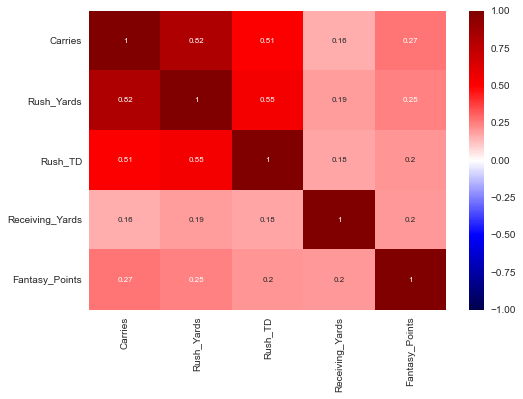

In [43]:
# example of a better corr matrix
# do this for all running backs, wide receivers, and quarterbacks
features_map = sns.heatmap(df_rushing_fantasy_2019.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"fontsize":8})
fig = features_map.get_figure()
fig.savefig("features_map.png") 

# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

<AxesSubplot:title={'center':'Pearson Ranking of 5 Features'}>

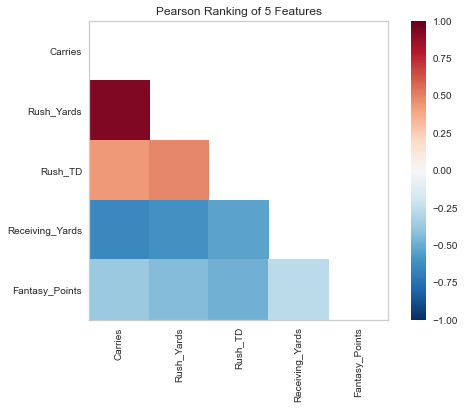

In [44]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df_rushing_fantasy_2019.corr())
visualizer.show(outpath="pcoords.png")

<Figure size 1440x540 with 0 Axes>

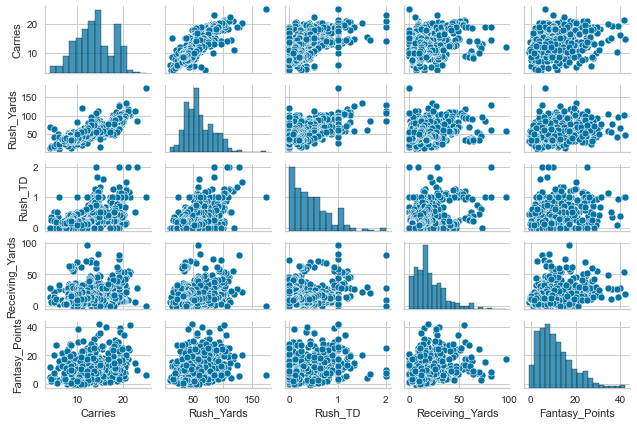

In [45]:
# do this for all running backs, wide receivers, and quarterbacks
plt.figure(figsize = [20,7.5])

sns.pairplot(df_rushing_fantasy_2019, height=1.2, aspect=1.5);

# Section 3: Cross-Validation For Model Selection

Demonstrates two typical workflows for using validation data to select models. It also demonstrates the use of some utility methods like generating **polynomial features** and **scaling features** when applying regularization.

**Contents Below**

> 1. Basic validation method: Train/validation/test
> 2. Rigorous validation method: Cross-validation/test
> 3. Making CV less manual via scikit-learn

## 3.1 Simple Validation Method: Train / Validation / Test

Break data into 3 portions: 60% for training, 20% for validation (used to select the model), 20% for final testing evaluation.

In [46]:
X, y = df_rushing_fantasy_2019.drop('Fantasy_Points',axis=1), df_rushing_fantasy_2019['Fantasy_Points']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20) 

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

Model Setup: **when using regularization, we must standardize** the data so that all features are on the same scale (we subtract the mean of each column and divide by the standard deviation, giving us features with mean 0 and std 1). Since this scaling is part of our model, we need to scale using the training set feature distributions and apply the same scaling to validation and test without refitting the scaler. 

Also, we need to get **polynomial features** for the poly model

In [48]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Higher alpha = strong regularization strength 
lm_las = Lasso(alpha=0.05)
lm_reg = Ridge(alpha=100)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

<AxesSubplot:>

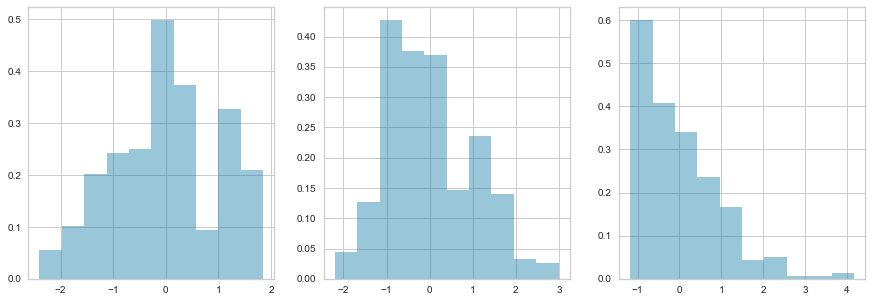

In [49]:
# Plot histograms of a few transformed variables
# Note that they seem to have means of 0 and stddevs of 1
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(X_train_scaled[:, 0], label='feature 1', ax=axes[0], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 1], label='feature 2', ax=axes[1], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 2], label='feature 3', ax=axes[2], kde=False, bins=10, norm_hist=True)


## Section 3.2 
Calculate R^2 Train, Validation, and Test values for Linear, Polynomial, Lass, and Regression

In [50]:
lm.fit(X_train_scaled, y_train)
print(f'Linear Regression Train R^2: {lm.score(X_train_scaled, y_train):.3f}')
print(f'Linear Regression Val R^2: {lm.score(X_val_scaled, y_val):.3f}')
print(f'Linear Regression Test R^2: {lm.score(X_test_scaled, y_test):.3f}\n')

lm_las.fit(X_train_scaled, y_train)

print(f'Lasso Regression Train R^2: {lm_las.score(X_train_scaled, y_train):.3f}')
print(f'Lasso Regression Val Scaled R^2: {lm_las.score(X_val_scaled, y_val):.3f}')
print(f'Lasso Regression Test R^2: {lm_las.score(X_test_scaled, y_test):.3f}\n')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression Train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression Val Scaled R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression Test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}\n')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression Train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
print(f'Degree 2 polynomial regression Val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression Test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

Linear Regression Train R^2: 0.093
Linear Regression Val R^2: 0.015
Linear Regression Test R^2: 0.180

Lasso Regression Train R^2: 0.093
Lasso Regression Val Scaled R^2: 0.017
Lasso Regression Test R^2: 0.177

Ridge Regression Train R^2: 0.090
Ridge Regression Val Scaled R^2: 0.033
Ridge Regression Test R^2: 0.160

Degree 2 polynomial regression Train R^2: 0.128
Degree 2 polynomial regression Val R^2: -0.012
Degree 2 polynomial regression Test R^2: 0.109


So having run this validation step, we see that the evidence points to Poloynomial having the highest Train R^2  but the lowest Validation and Test R^2s. Linear, Ridge, and Lasso have higher Validation and Test scores. We will focus Linear model for the rest of the study and utilize Lasso and Ridge regression for Feature Engineering selection. So our validation process lets us **select** that choice of model, and as our final step we retrain it on the entire chunk of train/val data and see how it does on test data:  

# Section 4 Rigorous Validation Method: Cross-Validation / Test

Break data into 2 portions: 80% for a cross-validated training process, and 20% for final testing evaluation. 

The idea of CV is to make efficient use of the data available to us (using 80% instead of 60% above), while also performing multiple validation checks. For k-fold CV, we come up with k train/validation splits of the whole chunk of data, in such a way that **each observation is in the validation set exactly 1 time**. 

We'll focus on Linear, Ridge, and Lasso regression (we also can feel pretty comfortable throwing out the full degree 2 polynomial regression based on the poor results above!) As we loop through our CV folds, we will train and validate both models and collect the results to compare at the end. Note that we scale the training features within the CV loop.

## Section 4.1 
Linear, Lasso, and Ridge Cross-Validation Scores and RSME

In [51]:
#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [52]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_train_r2s, cv_lm_val_r2s, cv_lm_las_train_r2s, cv_lm_las_val_r2s, cv_lm_reg_train_r2s, cv_lm_reg_val_r2s, cv_lm_poly_train_r2s, cv_lm_poly_val_r2s, rmses, rmses_las, rmses_reg, rmses_poly = [], [], [], [], [], [], [], [], [], [], [], [] #collect the validation results for models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm.fit(X_train, y_train)
    cv_lm_train_r2s.append(lm.score(X_train, y_train))
    cv_lm_val_r2s.append(lm.score(X_val, y_val))

    lm_rmse = mean_squared_error(y_val, lm.predict(X_val), squared=False)
    rmses.append(lm_rmse)

    # setup for ridge, lasso, and polynomial
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    #lass with feature scaling 
    lm_las.fit(X_train_scaled, y_train)
    cv_lm_las_train_r2s.append(lm_las.score(X_val_scaled,y_val))
    cv_lm_las_val_r2s.append(lm_las.score(X_val_scaled, y_val))

    lm_las_rmse = mean_squared_error(y_val, lm_las.predict(X_val_scaled), squared=False)
    rmses_las.append(lm_las_rmse)

    #ridge with feature scaling
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_train_r2s.append(lm_reg.score(X_val_scaled,y_val))
    cv_lm_reg_val_r2s.append(lm_reg.score(X_val_scaled, y_val))

    lm_reg_rmse = mean_squared_error(y_val, lm_reg.predict(X_val_scaled), squared=False)
    rmses_reg.append(lm_reg_rmse)

    #polynomial with feature scaling
    lm_poly.fit(X_train_scaled, y_train)
    cv_lm_poly_train_r2s.append(lm_las.score(X_val_scaled,y_val))
    cv_lm_poly_val_r2s.append(lm_poly.score(X_val_scaled, y_val))

    lm_poly_rmse = mean_squared_error(y_val, lm_poly.predict(X_val_scaled), squared=False)
    rmses_poly.append(lm_poly_rmse)

print('Simple regression scores: ', cv_lm_val_r2s)
print('Lasso scores: ', cv_lm_las_val_r2s, '\n')
print('Ridge scores: ', cv_lm_reg_val_r2s, '\n')
print('Polynomial scores:', cv_lm_poly_val_r2s, '\n')

print(f'Lasso mean cv r^2 (TRAIN): {np.mean(cv_lm_las_train_r2s):.3f} +- {np.std(cv_lm_las_train_r2s):.3f}')
print(f'Lasso mean cv r^2 (VAL): {np.mean(cv_lm_las_val_r2s):.3f} +- {np.std(cv_lm_las_val_r2s):.3f}')
print(f'Lasso mean RMSE: {np.mean(rmses_las):.3f} +- {np.std(rmses_las):.3f}\n')

print(f'Ridge mean cv r^2 (TRAIN): {np.mean(cv_lm_reg_train_r2s):.3f} +- {np.std(cv_lm_reg_train_r2s):.3f}')
print(f'Ridge mean cv r^2 (VAL): {np.mean(cv_lm_reg_val_r2s):.3f} +- {np.std(cv_lm_reg_val_r2s):.3f}')
print(f'Ridge mean RMSE: {np.mean(rmses_reg):.3f} +- {np.std(rmses_reg):.3f}\n')

print(f'Polynomial mean cv r^2 (TRAIN): {np.mean(cv_lm_poly_train_r2s):.3f} +- {np.std(cv_lm_poly_train_r2s):.3f}')
print(f'Polynomial mean cv r^2 (VAL): {np.mean(cv_lm_poly_val_r2s):.3f} +- {np.std(cv_lm_poly_val_r2s):.3f}')
print(f'Polynomial mean RMSE: {np.mean(rmses_poly):.3f} +- {np.std(rmses_poly):.3f}\n')

print(f'Simple mean cv r^2 (TRAIN): {np.mean(cv_lm_train_r2s):.3f} +- {np.std(cv_lm_train_r2s):.3f}')
print(f'Simple mean cv r^2 (VAL): {np.mean(cv_lm_val_r2s):.3f} +- {np.std(cv_lm_val_r2s):.3f}')
print(f'Simple mean RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')

Simple regression scores:  [-0.02401419106784286, 0.038980829564638, 0.047703901923687675, 0.09917230551534606, 0.10262032494491335]
Lasso scores:  [-0.022304909028667996, 0.040611181996302426, 0.0481486904169528, 0.09916065850567302, 0.09989281825207919] 

Ridge scores:  [-0.015991048732750812, 0.047815648892688745, 0.04976301840375319, 0.10001420001111672, 0.09305349373571936] 

Polynomial scores: [-0.02401419106784264, 0.038980829564638, 0.0477039019236879, 0.09917230551534606, 0.10262032494491324] 

Lasso mean cv r^2 (TRAIN): 0.053 +- 0.045
Lasso mean cv r^2 (VAL): 0.053 +- 0.045
Lasso mean RMSE: 7.524 +- 0.546

Ridge mean cv r^2 (TRAIN): 0.055 +- 0.041
Ridge mean cv r^2 (VAL): 0.055 +- 0.041
Ridge mean RMSE: 7.518 +- 0.557

Polynomial mean cv r^2 (TRAIN): 0.053 +- 0.045
Polynomial mean cv r^2 (VAL): 0.053 +- 0.046
Polynomial mean RMSE: 7.524 +- 0.543

Simple mean cv r^2 (TRAIN): 0.079 +- 0.009
Simple mean cv r^2 (VAL): 0.053 +- 0.046
Simple mean RMSE: 7.524 +- 0.543


The cross validation method cements simple linear regression being better than Lasso, Ridge, and Polynomial with a higher R^2 Train value.

**Since k-fold is more reliable than a single validation set, we are assured by the linear regression model**. This shows the dangers of relying on simple validation methods, especially when our sample sizes are small.

## Section 4.2
Determining coefficients to remove based on Ridge and Lasso coefficient values

**LASSO**:
* _Pro_: great for trimming features and focusing interpretation on a few key ones
* _Con_: risk of discarding features that are actually useful

**Ridge**:
* _Pro_: great for smoothly handling multicollinearity, very nice when working with sparse features 
* _Con_ (ish): will never fully discard features

Lasso coefficient scores of 0 have been removed for this final mode set.

In [53]:
list(zip(df_rushing_fantasy_2019.columns[:-1],lm_las.coef_))

[('Carries', 1.100345244600888),
 ('Rush_Yards', 0.2868461547878508),
 ('Rush_TD', 0.27576624962422164),
 ('Receiving_Yards', 0.8398075821162488)]

In [54]:
list(zip(df_rushing_fantasy_2019.columns[:-1],lm_reg.coef_))

[('Carries', 0.7690259716285296),
 ('Rush_Yards', 0.47123807084448993),
 ('Rush_TD', 0.3227509075529252),
 ('Receiving_Yards', 0.6901605312982221)]

# Section 5: Tuning Regularization Strength via Validation

Here we will attempt to find the "best" value of the regularization strength alpha for this feature and target set and the LASSO and Ridge models. We'll use simple validation (single train/valid split) as our model selection method.

We will first decide on a vector of "candidate" alpha values.  Then, for each candidate value, we run the following steps:

> 1. Fit a LASSO and Ridge model on the training data
> 2. Using the newly trained model, make predictions on the validation data
> 3. Run evaluation metrics on validation

Then we plot how the errors change for the different values of alpha, and see where alpha minimizes our error metric on the validation data. This value of alpha is the one we would select for our final model.

## Section 5.1: LASSO Regularization Tuning

In [55]:
test_set_pred = lm_las.predict(X_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

48.985446255727396

In [56]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

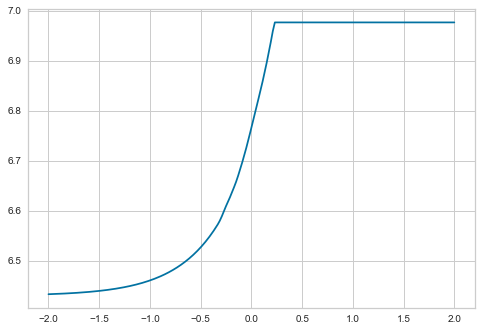

In [57]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [58]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

6.433373696635667

In [59]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

## Section 5.2: Ridge Regularization Tuning

In [60]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('Ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

In [61]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

6.430333085879374

In [62]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

## Section 5.3: LassoCV Regularization

In [63]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lm_las_CV = LassoCV(alphas = alphavec, cv=5)
lm_las_CV.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [64]:
# This is the best alpha value it found - higher from the value
# selected using simple validation
lm_las_CV.alpha_

0.08804883581643465

## Section 5.4: RidgeCV Regularization

In [65]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lm_reg_CV = RidgeCV(alphas = alphavec, cv=5)
lm_reg_CV.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [66]:
# This is the best alpha value it found - higher from the value
# selected using simple validation
lm_reg_CV.alpha_

100.0

#### Inputting either alphas for LASSO and Ridge did not impact the R^2 values significantly

# Section 6: Models

Comparing the Actual vs. Predicted values to determine accuracy of model 

## Section 6.1: Linear Regression Modeling 


Text(0, 0.5, 'Actual Values')

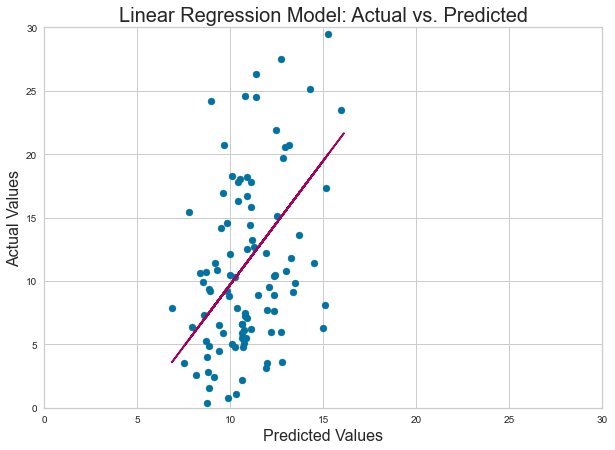

In [67]:
lm_predict = lm.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_predict, y_test)
ax = plt.gca()

z = np.polyfit(lm_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_predict, p(lm_predict), "m-")

plt.xlim(0,30)
plt.ylim(0,30)

plt.title('Linear Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Sectin 6.2 Lasso Regression Modeling 

Text(0, 0.5, 'Actual Values')

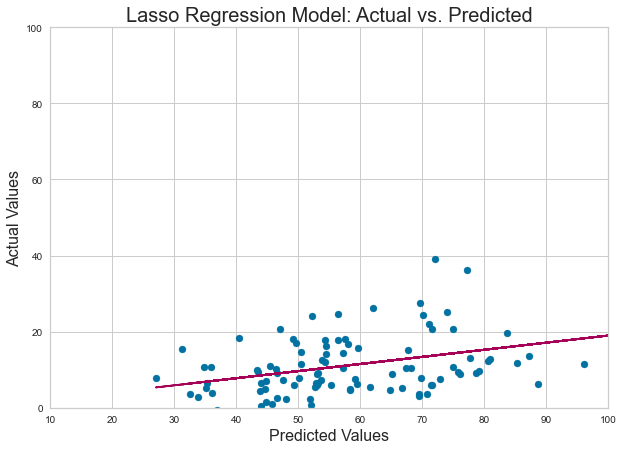

In [68]:
lm_las_predict = lm_las.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_las_predict, y_test)

z = np.polyfit(lm_las_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_las_predict, p(lm_las_predict), "m-")

plt.xlim(10,100)
plt.ylim(0,100)

plt.title('Lasso Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Section 6.3 Ridge Regression Modeling

Text(0, 0.5, 'Actual Values')

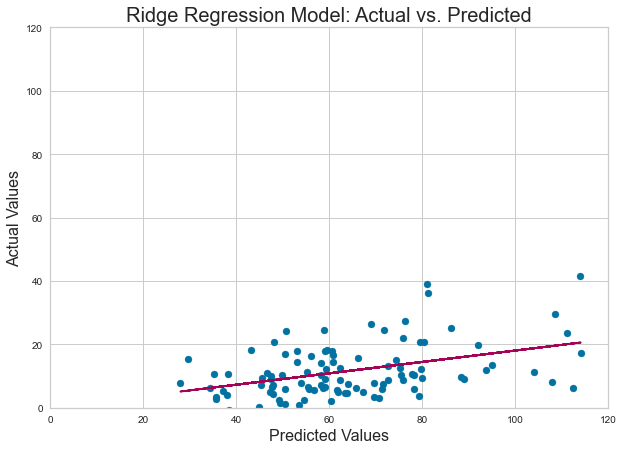

In [69]:
lm_reg_predict = lm_reg.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_reg_predict, y_test)

z = np.polyfit(lm_reg_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_reg_predict, p(lm_reg_predict), "m-")

plt.xlim(0,120)
plt.ylim(0,120)

plt.title('Ridge Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Section 6.4 Test vs. Predicted Values 
Comparing the Testing Values with the Predicted values and calculating the mean of the scores to analyze the difference.

In [79]:
df_rushing_fantasy_2019_predicted = df_rushing_fantasy_2019
df_rushing_fantasy_2019_predicted['Tested_Fantasy_Points'] = pd.DataFrame(y_test)
df_rushing_fantasy_2019_predicted['Predicted_Fantasy_Points'] = pd.DataFrame(lm_predict)
df_rushing_fantasy_2019_predicted['Name'] = all_running_backs_2019.iloc[:,1:2]
df_rushing_fantasy_2019_predicted = df_rushing_fantasy_2019_predicted.dropna()
df_rushing_fantasy_2019_predicted.to_csv('../final_df/Final_RB_Dataframe.csv', index=False)
df_rushing_fantasy_2019_predicted


,Carries,Rush_Yards,Rush_TD,Receiving_Yards,Fantasy_Points,Tested_Fantasy_Points,Predicted_Fantasy_Points,Name
2,17.000000,70.000000,1.000000,29.666667,10.8,10.8,15.148622,Derrick Henry
9,18.700000,83.200000,0.800000,16.700000,27.5,27.5,8.663872,Derrick Henry
10,18.727273,90.090909,0.909091,16.636364,20.6,20.6,10.805798,Derrick Henry
13,19.357143,94.928571,0.928571,14.714286,39.1,39.1,11.124474,Derrick Henry
14,13.000000,53.000000,1.000000,10.000000,18.0,18.0,11.111058,Ezekiel Elliott
16,18.333333,96.333333,0.666667,11.000000,10.5,10.5,11.887269,Ezekiel Elliott
17,18.250000,81.000000,0.750000,15.750000,15.1,15.1,8.581541,Ezekiel Elliott
19,18.833333,81.833333,0.833333,23.333333,20.7,20.7,12.487218,Ezekiel Elliott
29,17.000000,75.000000,0.000000,10.000000,15.8,15.8,9.380057,Nick Chubb
31,19.333333,77.666667,0.333333,27.000000,36.3,36.3,11.483024,Nick Chubb


In [80]:
df_rushing_fantasy_2019_predicted.iloc[:,-3:-1].mean()

Tested_Fantasy_Points       19.708000
Predicted_Fantasy_Points    10.747264
dtype: float64

# Section 7: Residuals Plots 

Residual plot comparing actual vs. predicted values. In a good model we want our errors to be random which the model shows.

In [76]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Fantasy_Points ~ Carries + Rush_Yards + Rush_TD + Receiving_Yards'
 
, data=df_rushing_fantasy_2019, 
return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     14.06
Date:                Sun, 11 Oct 2020   Prob (F-statistic):           7.07e-11
Time:                        21:57:53   Log-Likelihood:                -1729.5
No. Observations:                 504   AIC:                             3469.
Df Residuals:                     499   BIC:                             3490.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.3241      1.265      2.627      0.009       0.838       5.810
Carries             0.3861      0.148      2.607      0.009       0.095       0.677
Rush_Yards          0.0070      0.026      0.269      0.788      -0.044       0.059
Rush_TD             1.4063      1.090      1.290      0.198      -0.736       3.548
Receiving_Yards     0.0781      0.022      3.511      0.000       0.034       0.122
==============================================================================
Omnibus:                       83.839   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.504
Skew:                           1.079   Prob(JB):                     2.06e-28
Kurtosis:                       4.189   Cond. No.                         272.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

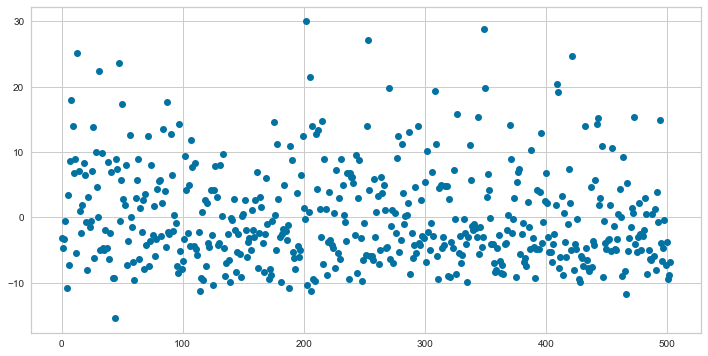

In [74]:
fit.resid.plot(style='o',figsize=(12,6))